## Beacon Chain Block Proposer Archival System

### Create a decentralized system that archives and provides access to block proposers beyond the 8191 block limit imposed by EIP-4788, using Chainlink Automation for regular updates.

### Merkle Proof 

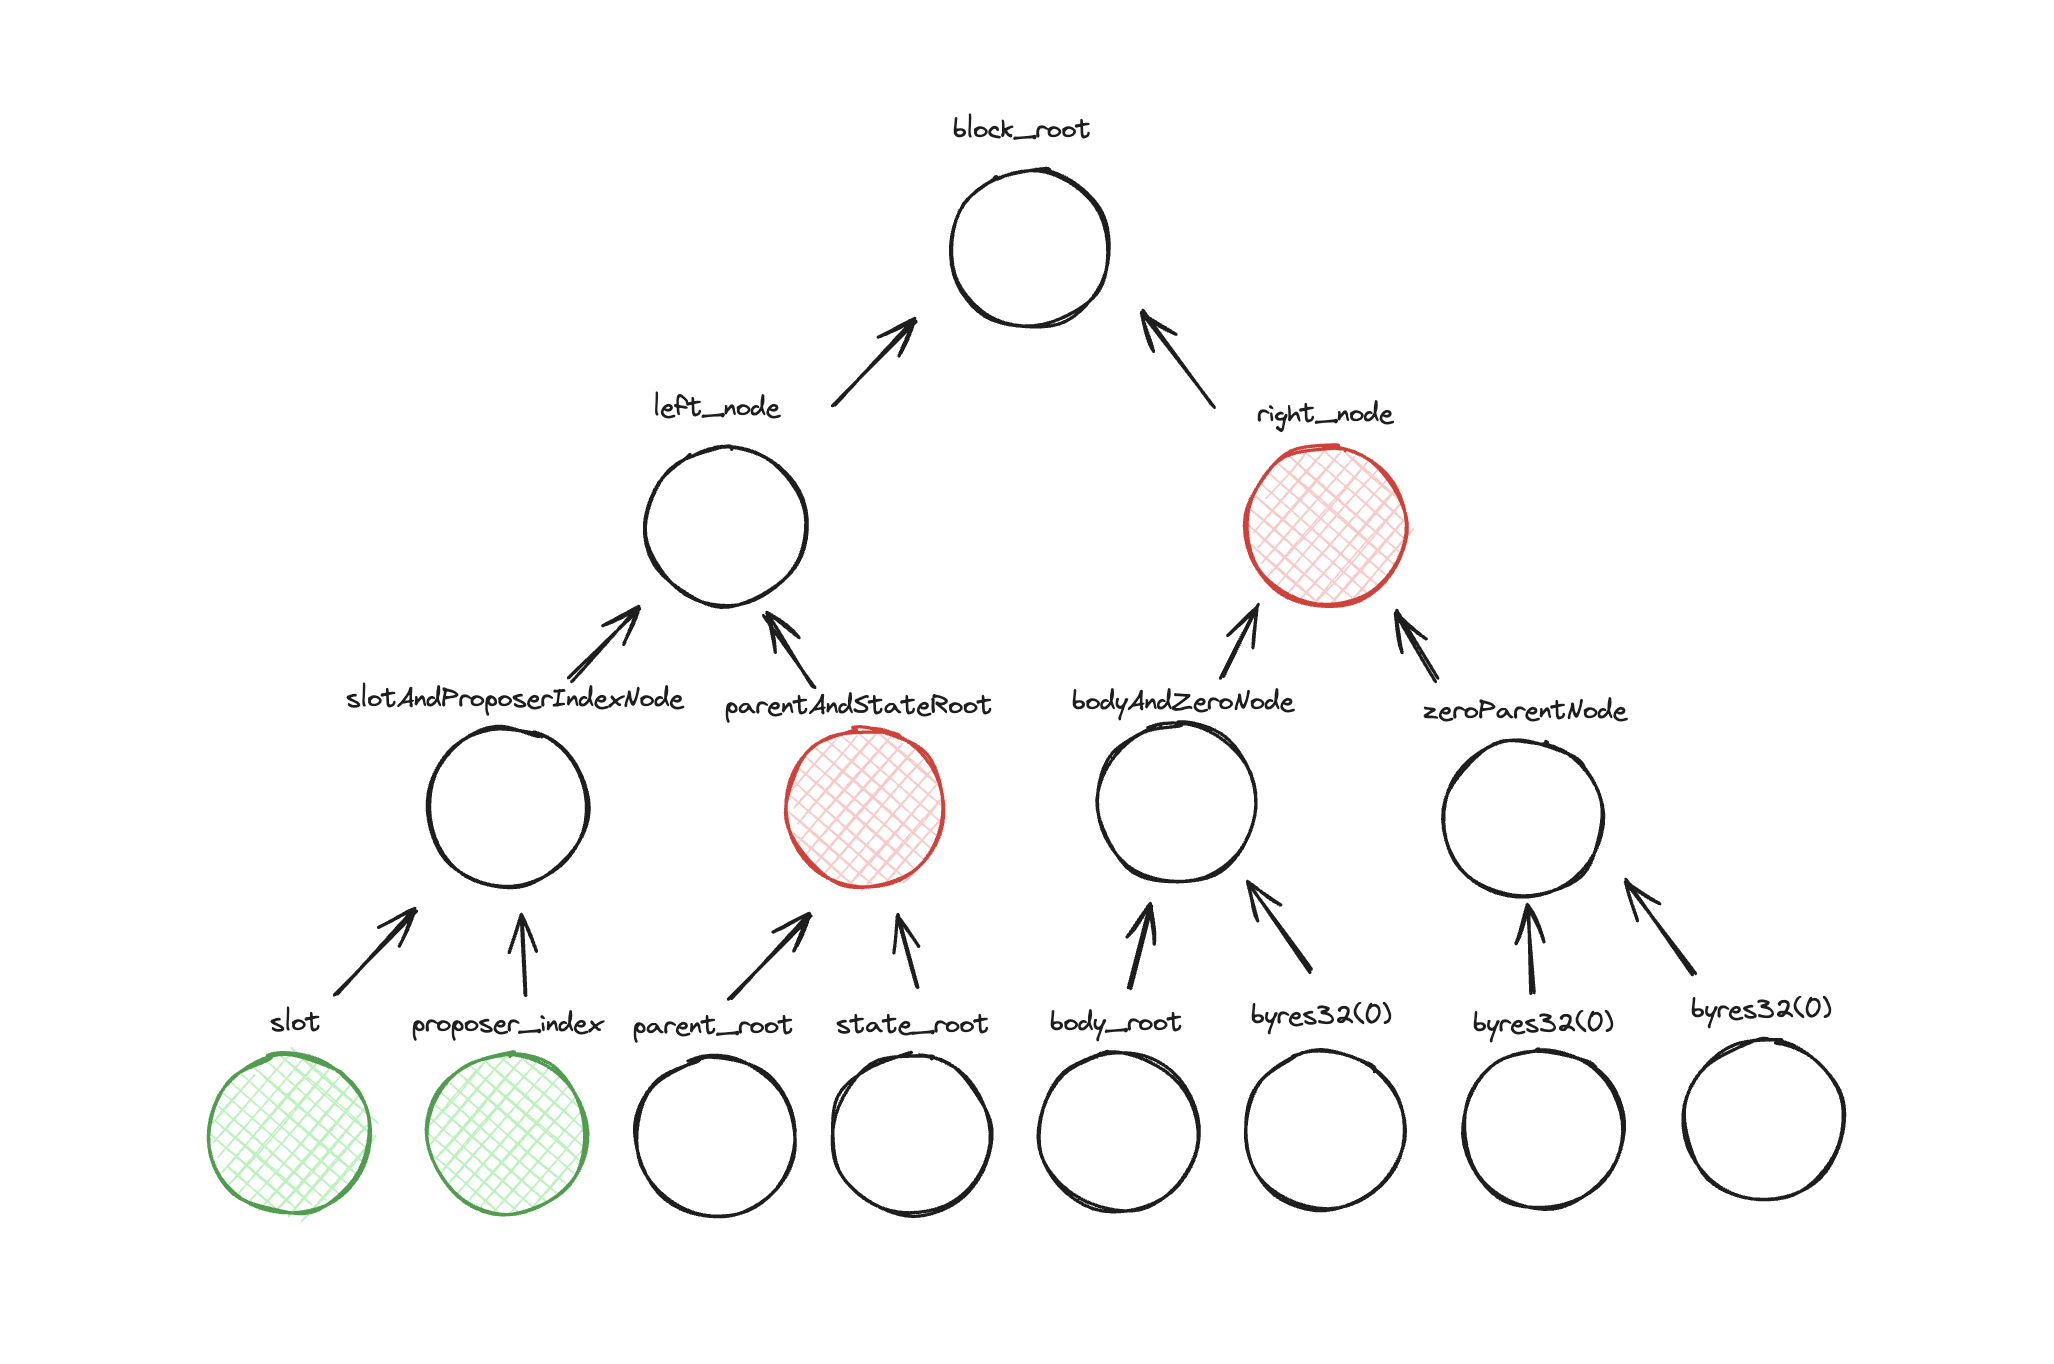

In [3]:
from IPython.display import Image, display

display(Image(filename='/Users/jessicavranek/Documents/Hackathon-BeaKeeper-24/img/merkleproof.png'))

Sanity Check process:

- proposer_index -> bytes32 -> Slot -> bytes32  -> hash -> slotandproposerindexnode 
- Parent_root -> bytes32 -> state_root -> bytes32 -> hash -> proof(0) / parentandstatenode
- hash(slotandproposerindexnode + proof(0) / parentandstatenode) -> left node
- body_root -> bytes32 -> bytes32(0) -> hash -> bodyandzero 
- Hash(bytes32(0) + bytes32(0)) -> zeroesparent
- Hash(bodyandzero + zeroesparent) -> proof(1) / right node
- hash(leftnode + right node) -> root 

In [35]:
from eth2spec.utils.ssz.ssz_typing import uint256, Bytes32
from eth2spec.utils.hash_function import hash
from eth2spec.utils.merkle_minimal import merkleize_chunks 
a = uint256(1).to_bytes(length = 32, byteorder='little')
b = uint256(2).to_bytes(length = 32, byteorder='little')
c = uint256(3).to_bytes(length = 32, byteorder='little')
d = uint256(4).to_bytes(length = 32, byteorder='little')
ab = hash(a + b)
cd = hash(c + d)
abcd = hash(ab + cd)
abcd.hex() == 'bfe3c665d2e561f13b30606c580cb703b2041287e212ade110f0bfd8563e21bb'

True

#### Block 1


{"block_root":"0xf5377637c999e92ad5a1118023cac6e91a0fd9fd5a4ad2b1a1d3aa865f8bafd4","body_root":"0x591213adb2ad0499dadaab30fa590c5bce833935b373536d0c110dea899f5292","parent_root":"0x53bfaaf85da750e4e0d181dceaa0016675be001ae1430dd9ceb5e7ed1f4e2255","proposer_index":"1613222","state_root":"0x4119938f7e4966b151a8cc733fd34063ead0aa2760839b9fe98ac2db4f290250","slot":"2066124"}



Slot = 2066124
proposer_index = 1613222
> 
Proof[0] = hash (parent_root) + (state_root) = hash(0x53bfaaf85da750e4e0d181dceaa0016675be001ae1430dd9ceb5e7ed1f4e2255) + (0x4119938f7e4966b151a8cc733fd34063ead0aa2760839b9fe98ac2db4f290250)
> this is where I will do offchain beacon block proof
Bodyandzeroes = hash(body_root) + (bytes32(0)) = hash(0x591213adb2ad0499dadaab30fa590c5bce833935b373536d0c110dea899f5292) + (0)
Zeroesparent = hash(bytes32(0)) + bytes32(0) = hex"f5a5fd42d16a20302798ef6ed309979b43003d2320d9f0e8ea9831a92759fb4b"
proof[1] = hash(bodyandzeroes) + (zeroesparent) -> ?

block_root_bytes.hex() = f5377637c999e92ad5a1118023cac6e91a0fd9fd5a4ad2b1a1d3aa865f8bafd4

root.hex() = f5377637c999e92ad5a1118023cac6e91a0fd9fd5a4ad2b1a1d3aa865f8bafd4

##### Initialize the variables

In [39]:
block_root = Bytes32("0xf5377637c999e92ad5a1118023cac6e91a0fd9fd5a4ad2b1a1d3aa865f8bafd4")
body_root = Bytes32("0x591213adb2ad0499dadaab30fa590c5bce833935b373536d0c110dea899f5292")
parent_root = Bytes32("0x53bfaaf85da750e4e0d181dceaa0016675be001ae1430dd9ceb5e7ed1f4e2255")
state_root = Bytes32("0x4119938f7e4966b151a8cc733fd34063ead0aa2760839b9fe98ac2db4f290250")
proposer_index = uint256(1613222).to_bytes(length = 32, byteorder='little')
slot = uint256(2066124).to_bytes(length = 32, byteorder='little')
zero = uint256(0).to_bytes(length = 32, byteorder='little')

##### Hash Intermediary Nodes

In [40]:
slotAndProposerIndexNode = hash(slot + proposer_index)
parentAndStateRootNode = hash(parent_root + state_root)
bodyAndZeroNode = hash(body_root + zero)
# zeroesParentNode = bytes.fromhex("f5a5fd42d16a20302798ef6ed309979b43003d2320d9f0e8ea9831a92759fb4b")
# zeroesParentNode = int(hash(bytes(32) + bytes(32)).hex(), 16).to_bytes(length = 32, byteorder='little').hex()
zeroesParentNode = hash(zero + zero) 


##### Hash Parent Intermediary Node

In [41]:
rightNode = hash(slotAndProposerIndexNode + parentAndStateRootNode)
leftNode = hash(bodyAndZeroNode + zeroesParentNode)

##### Hash Root Node

In [42]:
root = hash(rightNode + leftNode)
root.hex()

'f5377637c999e92ad5a1118023cac6e91a0fd9fd5a4ad2b1a1d3aa865f8bafd4'

##### Block Root

In [43]:
block_root.hex()

'f5377637c999e92ad5a1118023cac6e91a0fd9fd5a4ad2b1a1d3aa865f8bafd4'

#### Block 2

{"block_root":"0xaf812eb1cad879026d97f8a57817f6402c5feada6ead9f6e5ac446a0b38d77ab","body_root":"0x4929e5b2a9a42073b86f242e56a74e714fc65cbf25f735a5ea466513bb4fe1bb","parent_root":"0xf5377637c999e92ad5a1118023cac6e91a0fd9fd5a4ad2b1a1d3aa865f8bafd4","proposer_index":"478840","state_root":"0x035019ae6c36735ec468aafa773fc7d35e1940363f1021d90c77ab98c2c87efb","slot":"2066125"}

## Python Code (with functions)

In [44]:
def initialize_data():
    block_root = Bytes32("0xf5377637c999e92ad5a1118023cac6e91a0fd9fd5a4ad2b1a1d3aa865f8bafd4")
    body_root = Bytes32("0x591213adb2ad0499dadaab30fa590c5bce833935b373536d0c110dea899f5292")
    parent_root = Bytes32("0x53bfaaf85da750e4e0d181dceaa0016675be001ae1430dd9ceb5e7ed1f4e2255")
    state_root = Bytes32("0x4119938f7e4966b151a8cc733fd34063ead0aa2760839b9fe98ac2db4f290250")
    proposer_index = uint256(1613222).to_bytes(length=32, byteorder='little')
    slot = uint256(2066124).to_bytes(length=32, byteorder='little')
    zero = uint256(0).to_bytes(length=32, byteorder='little')
    return block_root, body_root, parent_root, state_root, proposer_index, slot, zero

In [45]:
def calculate_proof_nodes(slot, proposer_index, parent_root, state_root, body_root, zero):
    slot_and_proposer_index_node = hash(slot + proposer_index)
    parent_and_state_root_node = hash(parent_root + state_root)
    body_and_zero_node = hash(body_root + zero)
    zeroes_parent_node = hash(zero + zero)
    return slot_and_proposer_index_node, parent_and_state_root_node, body_and_zero_node, zeroes_parent_node

In [46]:
def calculate_final_root(slot_and_proposer_index_node, parent_and_state_root_node, body_and_zero_node, zeroes_parent_node):
    right_node = hash(slot_and_proposer_index_node + parent_and_state_root_node)
    left_node = hash(body_and_zero_node + zeroes_parent_node)
    final_root = hash(right_node + left_node)
    return final_root


In [47]:
def verify_root(final_root, block_root):
    return final_root == block_root

In [50]:
# def main():
block_root, body_root, parent_root, state_root, proposer_index, slot, zero = initialize_data()

slot_and_proposer_index_node, parent_and_state_root_node, body_and_zero_node, zeroes_parent_node = calculate_proof_nodes(
    slot, proposer_index, parent_root, state_root, body_root, zero
)

final_root = calculate_final_root(
    slot_and_proposer_index_node, parent_and_state_root_node, body_and_zero_node, zeroes_parent_node
)

is_valid = verify_root(final_root, block_root)

print(f"Calculated root: {final_root.hex()}")
print(f"Expected block root: {block_root.hex()}")
print(f"Root verification result: {is_valid}")

# if __name__ == "__main__":
#     main()

Calculated root: f5377637c999e92ad5a1118023cac6e91a0fd9fd5a4ad2b1a1d3aa865f8bafd4
Expected block root: f5377637c999e92ad5a1118023cac6e91a0fd9fd5a4ad2b1a1d3aa865f8bafd4
Root verification result: True
